# Paper_Predict_1

### Binomial Classification

In [176]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
# ANN
from sklearn.neural_network import MLPClassifier
# 랜덤포레스트, 그래디언트 부스팅
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier,HistGradientBoostingClassifier
from xgboost import XGBClassifier
# 그리드 서치
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix,recall_score,roc_auc_score
import time

import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt

2022-06-07 23:38:10.172203: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-07 23:38:10.172240: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [173]:
!pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 4.5 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.7/123.7 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 40.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 36.2 MB/s eta 0:00:00m eta 0:00:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 37.5 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 41.0 MB/s eta 0:00:0031m58.6 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 51.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 40.1 MB/s eta 0:00:

  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4847 sha256=e1274825a0adb3ffb63f01da942e54bf1e46e15e76b4723c40c2778d1d0af4c6
  Stored in directory: /home/piai/.cache/pip/wheels/b6/0d/90/0d1bbd99855f99cb2f6c2e5ff96f8023fad8ec367695f7d72d
Successfully built termcolor


# 데이터 불러오기

In [3]:
# filepath 입력
filepath = "/home/piai/test/Big_Data_분석_기초/제지공장 프로젝트/data/정제데이터/train_30_120_7.csv"
# 레이블 칼럼명 입력
label_col= "result"

In [5]:
df = pd.read_csv(filepath,index_col="Unnamed: 0")
df[label_col].value_counts()

0    73124
1      197
Name: result, dtype: int64

In [41]:
df.columns

Index(['TAG_001', 'TAG_002', 'TAG_003', 'TAG_004', 'TAG_005', 'TAG_006',
       'TAG_007', 'TAG_008', 'TAG_009', 'TAG_010',
       ...
       'TAG_189', 'TAG_190', 'TAG_191', 'TAG_192', 'TAG_193', 'TAG_194',
       'TAG_195', 'TAG_196', 'result', 'datetime'],
      dtype='object', length=198)

In [42]:
col_num = "003 010 019 036 039 051 055 061 081 082 083 091 092 093 094 095 096 097 098 117 118 121 124 125 126 173 176 196".split(' ')

In [43]:
col_num = ["TAG_{}".format(num) if len(col_num[0])==3 else num for num in col_num]

In [44]:
df_drop = df.drop([*col_num,"datetime"],axis=1)

In [45]:
df_droped = df_drop[~(df_drop[label_col]==2)]
df_droped[label_col].value_counts()

0    73124
1      197
Name: result, dtype: int64

In [46]:
df_x = df_droped.drop(label_col,axis=1,inplace=False)
df_y = df_droped[label_col]

In [47]:
df_train_x,df_test_x, df_train_y, df_test_y = train_test_split(df_x,df_y,test_size=0.3,random_state=1234)

In [48]:
df_test_y.value_counts()

0    21949
1       48
Name: result, dtype: int64

In [49]:
df_train_y.value_counts()

0    51175
1      149
Name: result, dtype: int64

## GB

In [50]:
para_leaf=[n_leaf * 1 for n_leaf in range(1,21)]
para_split=[n_split * 2 for n_split in range(1,21)]
para_depth=[depth for depth in range(2,11)]
para_n_tree=[n_tree*1 for n_tree in range(1,11)]
para_lr=[n_lr *0.1 for n_lr in range(1,11)]

In [184]:
start = time.time()
estimator = HistGradientBoostingClassifier(random_state=1234)
param_rand={
            "max_depth":para_depth,
#             "min_samples_split":para_split,
            "min_samples_leaf":para_leaf,
#             "n_estimators":para_n_tree,
            "learning_rate":para_lr
           }
rand_hgb = RandomizedSearchCV(estimator, param_rand, n_iter = 5, cv = 3, scoring="f1_micro", n_jobs=-1,verbose=0)
rand_hgb.fit(df_train_x,df_train_y)

RandomizedSearchCV(cv=3,
                   estimator=HistGradientBoostingClassifier(random_state=1234),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'learning_rate': [0.1, 0.2,
                                                          0.30000000000000004,
                                                          0.4, 0.5,
                                                          0.6000000000000001,
                                                          0.7000000000000001,
                                                          0.8, 0.9, 1.0],
                                        'max_depth': [2, 3, 4, 5, 6, 7, 8, 9,
                                                      10],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10, 11,
                                                             12, 13, 14, 15, 16,
                                                             17, 18, 19, 20]},
                   scoring='f1_micro')

In [185]:
print("소요시간 :", time.time() - start)

소요시간 : 6.839227914810181


In [186]:
best_hgb = rand_hgb.best_estimator_
best_hgb

HistGradientBoostingClassifier(learning_rate=0.6000000000000001, max_depth=8,
                               min_samples_leaf=2, random_state=1234)

In [187]:
hgb_result = best_hgb.fit(df_train_x,df_train_y)
print("Score on training set  {:.3f}".format(best_hgb.score(df_train_x, df_train_y)))
print("Score on testing set  {:.3f}".format(best_hgb.score(df_test_x, df_test_y)))

Score on training set  0.997
Score on testing set  0.996


## XGB - use_missing=False가 Nan값을 무시하고 학습하라는 파라미터

In [165]:
start = time.time()

In [56]:
estimator = XGBClassifier(random_state=1234,use_missing=False)
param_rand={
            "learning_rate":para_lr,    
            "max_depth":para_depth,
            "n_estimators":para_n_tree
           }
rand_xgb = RandomizedSearchCV(estimator, param_rand, n_iter = 5, cv = 10, scoring="f1", n_jobs=-1,verbose=0)
rand_xgb.fit(df_train_x,df_train_y)

[23:09:14] WARNING: ../src/learner.cc:627: 
Parameters: { "use_missing" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




RandomizedSearchCV(cv=10,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None...
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=1234,
                                           reg_alpha=None, reg_lambda=None, ...),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'learning_rate': [0.1, 0.2,
                                                          0.30000000000000004,
                                                          0.4, 0.5,
                                                          0.6000000000000001,
                                                          0.7000000000000001,
                                                          0.8, 0.9, 1.0],
                                        'max_depth': [2, 3, 4, 5, 6, 7, 8, 9,
                                                      10],
                                        'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8,
                                                         9, 10]},
                   scoring='f1')

In [57]:
print("소요시간 :", time.time() - start)

소요시간 : 110.71462106704712


In [58]:
best_xgb = rand_xgb.best_estimator_
best_xgb

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.9, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=6, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=1234,
              reg_alpha=0, reg_lambda=1, ...)

In [59]:
xgb_result = best_xgb.fit(df_train_x,df_train_y)
print("Score on training set  {:.3f}".format(best_xgb.score(df_train_x, df_train_y)))
print("Score on testing set  {:.3f}".format(best_xgb.score(df_test_x, df_test_y)))

[23:09:17] WARNING: ../src/learner.cc:627: 
Parameters: { "use_missing" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Score on training set  0.998
Score on testing set  0.997


# 변수 중요도

In [60]:
# print(best_hgb.feature_importances_.round(3))
print(best_xgb.feature_importances_.round(3))

[0.001 0.007 0.011 0.    0.    0.041 0.    0.    0.    0.    0.    0.
 0.013 0.    0.014 0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.027 0.    0.006 0.    0.    0.033 0.    0.015 0.008
 0.008 0.01  0.024 0.018 0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.02  0.    0.    0.    0.    0.    0.019 0.001
 0.    0.047 0.    0.    0.    0.018 0.005 0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.01  0.    0.    0.    0.041 0.031 0.001 0.004
 0.    0.022 0.001 0.    0.001 0.    0.023 0.    0.    0.    0.013 0.
 0.    0.    0.    0.    0.    0.    0.019 0.    0.004 0.018 0.    0.
 0.026 0.017 0.    0.    0.    0.006 0.008 0.016 0.011 0.021 0.    0.
 0.    0.02  0.    0.005 0.023 0.008 0.    0.    0.    0.016 0.001 0.
 0.    0.    0.    0.022 0.    0.    0.    0.006 0.    0.033 0.    0.
 0.024 0.    0.04  0.    0.008 0.    0.    0.    0.    0.024 0.011 0.009
 0.    0.    0.    0.011 0.008 0.    0.024 0.    0.04  0.002 0.025 0.   ]


In [61]:
# 변수중요도 상위 몇 개?
top_importance = 5

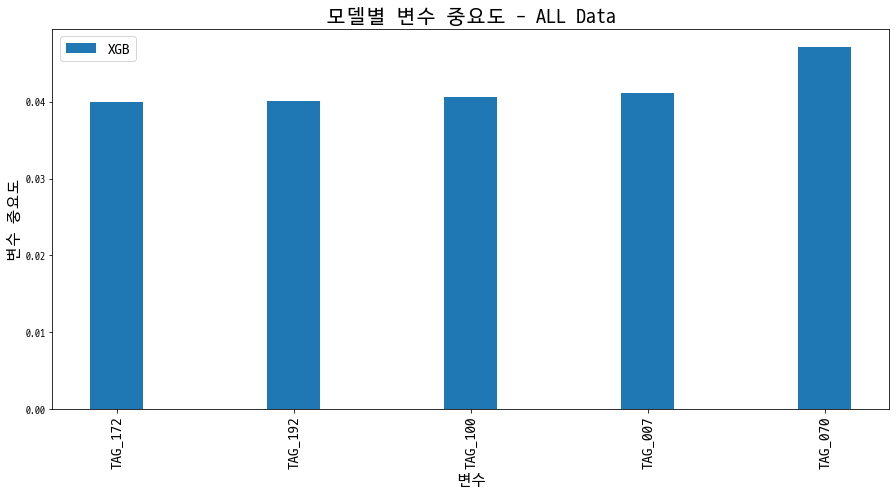

In [62]:
v_feature_name = df_train_x.columns

df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
# df_importance["DT_Importance"] = best_dt.feature_importances_
# df_importance["RF_Importance"] = best_rf.feature_importances_
# df_importance["HGB_Importance"] = best_hgb.feature_importances_
df_importance["XGB_Importance"] = best_xgb.feature_importances_
df_importance.sort_values("XGB_Importance", ascending=True, inplace=True)
# coordinates_dt = [i for i in range(len(df_importance))]
# coordinates_hgb = [i+0.3 for i in range(len(df_importance))]
coordinates_xgb = [i+0.6 for i in range(len(df_importance))]
# coordinates_rf = [i for i in range(len(df_importance))]
plt.figure(figsize=(15,7))
# plt.bar(x=coordinates_dt, height=df_importance['DT_Importance'],width=0.3,label="DT")
# plt.bar(x=coordinates_rf, height=df_importance['RF_Importance'],width=0.3,label="RF")
# plt.bar(x=coordinates_hgb, height=df_importance['HGB_Importance'],width=0.3,label="GB")
plt.bar(x=coordinates_xgb[-top_importance:], height=df_importance['XGB_Importance'][-top_importance:],width=0.3,label="XGB")
plt.legend(fontsize=15)
plt.title("모델별 변수 중요도 - ALL Data",fontsize=20)
plt.xticks(coordinates_xgb[-top_importance:],df_importance['Feature'][-top_importance:],rotation=90,fontsize=15)
plt.ylabel("변수 중요도",fontsize=15)
plt.xlabel("변수",fontsize=15)
plt.show()

## 모델 성능

### HGB

In [188]:
y_pred = hgb_result.predict(df_test_x)
y_pred_proba = (hgb_result.predict_proba(df_test_x)[:,1] >= 0.3).astype(bool)

In [190]:
print("Confusion Matrix:\n{}\n".format(confusion_matrix(df_test_y,y_pred_proba)))

Confusion Matrix:
[[21906    43]
 [   48     0]]



In [169]:
f1_score(df_test_y,y_pred)

0.0

In [159]:
accuracy_score(df_test_y,y_pred)

0.9964995226621812

In [160]:
recall_score(df_test_y,y_pred)

0.0

### XGB

In [67]:
y_pred = xgb_result.predict(df_test_x)
print("Confusion Matrix:\n{}\n".format(confusion_matrix(df_test_y,y_pred)))

Confusion Matrix:
[[21938    11]
 [   48     0]]



In [68]:
f1_score(df_test_y,y_pred)

0.0

In [69]:
accuracy_score(df_test_y,y_pred)

0.9973178160658271

In [71]:
recall_score(df_test_y,y_pred)

0.0

In [171]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

NameError: name 'keras' is not defined

In [170]:
def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

NameError: name 'METRICS' is not defined

In [177]:
step_factor = 0.05 
threshold_value = 0.2 
roc_score=0
predicted_proba = hgb_result.predict_proba(df_test_x) #probability of prediction
while threshold_value <=0.8: #continue to check best threshold upto probability 0.8
    temp_thresh = threshold_value
    predicted = (predicted_proba [:,1] >= temp_thresh).astype('int') #change the class boundary for prediction
    print('Threshold',temp_thresh,'--',roc_auc_score(df_test_y, predicted))
    if roc_score<roc_auc_score(df_test_y, predicted): #store the threshold for best classification
        roc_score = roc_auc_score(df_test_y, predicted)
        thrsh_score = threshold_value
    threshold_value = threshold_value + step_factor
print('---Optimum Threshold ---',thrsh_score,'--ROC--',roc_score)

Threshold 0.2 -- 0.49990887967561165
Threshold 0.25 -- 0.4999316597567087
Threshold 0.3 -- 0.4999544398378058
Threshold 0.35 -- 0.4999772199189029
Threshold 0.39999999999999997 -- 0.5
Threshold 0.44999999999999996 -- 0.5
Threshold 0.49999999999999994 -- 0.5
Threshold 0.5499999999999999 -- 0.5
Threshold 0.6 -- 0.5
Threshold 0.65 -- 0.5
Threshold 0.7000000000000001 -- 0.5
Threshold 0.7500000000000001 -- 0.5
---Optimum Threshold --- 0.39999999999999997 --ROC-- 0.5


In [191]:
from sklearn.utils import class_weight

In [199]:
class_weights = class_weight.compute_class_weight("balanced",classes=np.unique(df_train_y),y=df_train_y)

In [202]:
hgb_result = best_hgb.fit(df_train_x,df_train_y,class_weight=class_weights)

TypeError: fit() got an unexpected keyword argument 'class_weight'